### SUMMARY:

    This notebook analyzes a CSV file of global cities and their associations
    (or lack thereof) with metropolitan statistical areas (MSAs). It develops
    a clustering algorithm that groups cities into MSAs using two major steps:

    1) Cities are clustered into groups based on their geographic (lon/lat)
    locations, using a k-means model that is weighted by cities' population
    sizes. This ensures that MSAs recognize cities that are spatially close
    to each other, are centered around cities with greater population sizes,
    and are generally more circular in shape (a feature of k-means), which
    maximizes their inclusivity.

    2) Each cluster from step 1 is sub-divided further into clusters based on
    cities' population sizes, using a DBSCAN model. This ensures that cities
    in non-metro or rural areas, which generally have smaller populations,
    are treated as separate entities from those in metro areas (especially
    since DBSCAN is effective at detecting population outliers).

    The notebook applies this algorithm both to cities within the USA and to
    all cities around the world.

### NOTE:

    A model / algorithm of MSAs is more useful than existing standard MSAs.
    Standard MSAs are designated manually and based on set rules (e.g., an
    urban area has a population of >= 50000 inhabitants). This makes them
    difficult to maintain and update as populations of cities change and as
    new population centers emerge. Standard MSAs are also only designated in
    the USA, and applying the standard manual approach to designate MSAs
    around the world would be tedious and difficult to execute. A model /
    algorithm circumvents these issues by being able to create MSA groupings
    around the world automatically and efficiently, and by being able to
    malleably update MSAs as new data, population trends, and/or MSA rules
    become available.

    To demonstrate the malleability of an MSA model / algorithm, this
    notebook can quickly change the designation of an urban area from having
    a population of >= 50000 to some other threshold value, and then can
    apply that change globally. In fact, an alternative threshold of >= 100000
    led to improved clustering model performance compared to the more
    traditional >= 50000 (see the "THRES_POP" constant below).
    
### TODO:

    The analyses here are presented in a Jupyter notebook, as a notebook
    allows for results to be shared easily and to be presented in a more
    human-readable way. However, as needed, the notebook could be modified
    into a Python script that could be run on a schedule and/or could save
    all results and visualizations into a directory (instead of printing
    them out, as is done here).

### TODO:

    It may be useful for better organization to place the functions that
    are defined below into separate Python files.

In [1]:
# Import the libraries that will be used in this analysis.
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
# List the constants that will be used in this analysis (alphabetically).
COLNAME_CLUSTER_DBSCAN = 'msa_cluster_dbscan'
COLNAME_CLUSTER_FINAL = 'msa_cluster_final'
COLNAME_CLUSTER_KMEANS = 'msa_cluster_kmeans'

COLNAME_COUNTRY = 'country'
COLNAME_ENCODED = 'msa_encoded'
COLNAME_ID = 'id'
COLNAME_LON = 'longitude'
COLNAME_LAT = 'latitude'
COLNAME_MSA = 'msa'
COLNAME_POP = 'population'
COLNAME_POP_TRANS = 'population_trans'
COLNAME_UNNAMED = 'Unnamed'

COLOR_BAR = False
COLOR_MAP = 'Accent'

CSV_FILEMODE = 'wb'
CSV_FILENAME = 'msa_data.csv'

DATA_URL = ''

DBSCAN_EPS = 0.0001
DBSCAN_MIN = 500

LABEL_LAT = 'Latitude (Degrees)'
LABEL_LON = 'Longitude (Degrees)'
LABEL_PAD = 20

NAME_USA = 'united states'

RANDOM_STATE = 100

SIZE_FIG = (10, 7)
SIZE_FONT_TICKS = 15
SIZE_FONT_LABEL = SIZE_FONT_TICKS + 5
SIZE_POINTS = 5
SIZE_SAMPLE = 7000

THRES_DIST = 0.0001
THRES_POP = 100000

In [3]:
# Define the preprocessing functions that will be used in this analysis.
def download_url_data(url, filename, mode=CSV_FILEMODE):
    """Download a data file from a URL.

    Args:
        url (string): URL where the data is located.
        filename (string): Name of the file to download the data.
        mode (string): Mode in which the file should be opened.

    Returns:
        file: Downloaded data file.
    """

    url_response = requests.get(url)
    with open(filename, mode) as f:
        f.write(url_response.content)


def change_colnames(df, pattern, newnames):
    """Change column names in a DataFrame whose names match a pattern.

    Args:
        df (Pandas DataFrame): DataFrame containing the columns.
        pattern (string): String pattern to search for.
        newnames (list): List of new column names to assign.

    Returns:
        Pandas DataFrame: DataFrame with new column names.
    """

    colnames_tochange = df.columns[df.columns.str.match(pattern)]
    if len(colnames_tochange) > 0:
        df.rename(
            columns=dict(zip(colnames_tochange, newnames)),
            inplace=True
        )
    return df


def encode_column(df, colname, colname_encoded):
    """Create a label-encoded version of a DataFrame column.

    Args:
        df (Pandas DataFrame): DataFrame containing the column.
        colname (string): Name of the DataFrame column to encode.
        colname_encoded (string): Name of the column with encoding.

    Returns:
        Pandas DataFrame: DataFrame with an encoded column added.
    """

    encoder = LabelEncoder()
    df.loc[:, colname_encoded] = (encoder.fit_transform(df.loc[:, colname]))
    return df


def scatterplot_points(
        df, colname_x=COLNAME_LON, colname_y=COLNAME_LAT,
        colname_c=COLNAME_ENCODED, size_points=SIZE_POINTS,
        color_map=COLOR_MAP, size_font_ticks=SIZE_FONT_TICKS,
        size_fig=SIZE_FIG, color_bar=COLOR_BAR, label_x=LABEL_LON,
        label_y=LABEL_LAT, size_font_label=SIZE_FONT_LABEL,
        label_pad=LABEL_PAD):
    """Make a scatterplot of points in a Pandas DataFrame.

    Args:
        df (Pandas DataFrame): DataFrame containing the points.
        colname_x (string): Name of the DataFrame column for the x-axis.
        colname_y (string): Name of the DataFrame column for the y-axis.
        colname_c (string): Name of the DataFrame column for the colors.
        color_map (string): Name of the colormap for the plot's points.
        size_points (int): Size of the plot's points.
        size_font_ticks (int): Size of the plot's tick labels.
        size_fig (tuple): Size of the plot (width * height in inches).
        color_bar (bool): Should a color bar be displayed in the plot?
        label_x (string): X-axis label for the plot.
        label_y (string): Y-axis label for the plot.
        size_font_label (int): Size of the plot's axis labels.
        label_pad (int): Distance between axis labels and ticks.

    Returns:
        Plot: Scatter plot of points.
    """

    ax = df.plot.scatter(
        x=colname_x,
        y=colname_y,
        c=colname_c,
        cmap=color_map,
        s=size_points,
        fontsize=size_font_ticks,
        figsize=size_fig,
        colorbar=color_bar
    )
    ax.set_xlabel(label_x, fontsize=size_font_label, labelpad=label_pad)
    ax.set_ylabel(label_y, fontsize=size_font_label, labelpad=label_pad)

    return ax

In [4]:
# Define the modeling functions that will be used in this analysis.
def model_locate_centroids(
        df, colname_thres=COLNAME_POP, thres=THRES_POP,
        colname_x=COLNAME_LON, colname_y=COLNAME_LAT, thres_dist=THRES_DIST):
    """Locate the spatial points that will be initial cluster centroids.

    Locate points that exhibit a value of a feature that is above a
    specified threshold, and then subset those points to remove those that
    are too close to others (to prevent duplicate initial centroids).

    Args:
        df (Pandas DataFrame): DataFrame containing the points.
        colname_thres (string): Name of the DataFrame column to threshold.
        thres (int): Threshold value from the "colname_thres" column.
        colname_x (string): Name of the DataFrame column with x-coords.
        colname_y (string): Name of the DataFrame column with y-coords.
        thres_dist (float): Threshold for maximum distance between points.

    Returns:
        Pandas DataFrame: DataFrame with coordinates of the located points.
    """

    df_thres = df[df[colname_thres] >= thres]
    df_thres = df_thres[[colname_x, colname_y]]
    dist_array = cdist(df_thres, df_thres)
    df_thres = df_thres[~np.tril(dist_array < thres_dist, k=-1).any(1)]
    return df_thres


def model_weighted_kmeans(
        init_centroids, df, random_state=RANDOM_STATE,
        colnames=[COLNAME_LON, COLNAME_LAT], colname_weights=COLNAME_POP_TRANS):
    """Build a k-means clustering model with points weighted by importance.

    Args:
        init_centroids (Pandas DataFrame): DataFrame with coordinates of
            the initial locations of the model's centroids.
        random_state (int): Random number to ensure result reproducibility.
        df (Pandas DataFrame): DataFrame containing the points to cluster.
        colnames (list): Name of the DataFrame columns to be considered
            by the model when clustering points.
        colname_weights (string): Name of the DataFrame column with weights.

    Returns:
        KMeans object: Object with outputs of the k-means model.
    """

    kmeans_model = (
        KMeans(n_clusters=len(init_centroids), init=init_centroids,
               n_init=1, random_state=random_state)
    )
    kmeans_model.fit(df[colnames], sample_weight=df[colname_weights])
    return kmeans_model


def model_clustering_algorithm(
        df, colname_first=COLNAME_CLUSTER_KMEANS,
        colname_second=COLNAME_CLUSTER_DBSCAN, colname_sub=COLNAME_POP_TRANS,
        eps=DBSCAN_EPS, min_samples=DBSCAN_MIN,
        colname_final=COLNAME_CLUSTER_FINAL):
    """Execute the algorithm for performing clustering analysis.

    Create a nested clustering algorithm where points are first clustered
    by one clustering model, and then the resultant clusters are further
    subdivided into sub-clusters. Store the output in DataFrame columns.
    Note that this function depends on the modeling functions above.

    Args:
        df (Pandas DataFrame): DataFrame containing the points to cluster.
        colname_first (string): Name of the DataFrame column with each
            point's affiliated cluster label from the first model.
        colname_second (string): Name of the DataFrame column with each
            point's affiliated cluster label from the second (sub) model.
        colname_sub (string): Name of the DataFrame column containing the
            feature on which initial clusters are to be sub-divided.
        eps (float): The epsilon parameter for the DBSCAN model.
        min_samples (int): Number of nearby points in a neighborhood for
            the DBSCAN model to consider a point to be a core point.
        colname_final (string): Name of the DataFrame column with each
            point's final affiliated cluster label.

    Returns:
        Pandas DataFrame: DataFrame with cluster labels for all points.
    """

    # Locate initial centroids and use them to model the first clusters.

    init_centroids = model_locate_centroids(df=df)
    kmeans = model_weighted_kmeans(init_centroids=init_centroids, df=df)
    df[colname_first] = kmeans.labels_

    # Subdivide the first clusters into sub-clusters based on "colname_sub".

    df[colname_second] = (
        df
        .groupby(colname_first)[colname_sub]
        .transform(
            lambda x:
                DBSCAN(eps=eps, min_samples=min_samples)
                .fit(x.values.reshape(-1, 1))
                .labels_
        )
    )

    # Combine the first and second cluster affiliations into a new column,
    # and label encode those combined affiliations.

    df[colname_final] = (
        df[colname_first].astype('str')
        + '_'
        + df[colname_second].astype('str')
    )
    df = encode_column(df, colname_final, colname_final)
    return df


def model_evaluate_clusters(
        df, colname_x=COLNAME_LON, colname_y=COLNAME_LAT,
        colname_final=COLNAME_CLUSTER_FINAL,
        size_sample=SIZE_SAMPLE, random_state=RANDOM_STATE):
    """Evaluate a clustering model using the silhouette score.

    The silhouette score is advantageous over other model evaluation
    metrics, because unlike many others, it is bounded by a defined range
    (-1 = poorest clustering to 1 = perfect clustering). Thus, the score
    is relatively easy to interpret, as its value can be logically compared
    to the overall value range.

    Args:
        df (Pandas DataFrame): DataFrame containing the clustered points.
        colname_x (string): Name of the DataFrame column with x-coords.
        colname_y (string): Name of the DataFrame column with y-coords.
        colname_final (string): Name of the DataFrame column with each
            point's final affiliated cluster label.
        size_sample (int): Number of sample points to use in evaluation.
        random_state (int): Random number to ensure result reproducibility.

    Returns:
        Float: Silhouette score value from -1 to 1.
    """

    df_lonlat = df.loc[:, [colname_x, colname_y]]
    clusters_eval = silhouette_score(
        X=cdist(df_lonlat, df_lonlat),
        labels=df[COLNAME_CLUSTER_FINAL],
        sample_size=size_sample,
        random_state=random_state
    )
    return clusters_eval

In [5]:
# Request and download the CSV file of interest.
download_url_data(DATA_URL, CSV_FILENAME)

In [6]:
# Read the downloaded CSV file into a Pandas DataFrame.
msa_data = pd.read_csv(CSV_FILENAME)

In [7]:
# Observe the first few rows of the DataFrame.
msa_data.head()

,Unnamed: 0,city,state,country,latitude,longitude,population,msa
0,0,mahopac,new york,united states,41.37232,-73.73346,8369,New York-Northern New Jersey-Long Island NY-NJ...
1,1,seven hills,ohio,united states,41.39533,-81.67624,11690,NaN
2,2,new martinsville,west virginia,united states,39.64452,-80.85760,5218,WV NONMETROPOLITAN AREA
3,3,sint anthonis,north brabant,netherlands,51.62667,5.88194,3340,NaN
4,4,machali,o higgins region,chile,-34.18082,-70.64933,27595,NaN


In [8]:
# Display how many rows and columns the DataFrame has.
msa_data.shape

(25410, 8)

In [9]:
# List the column names of the DataFrame.
msa_data.columns

Index(['Unnamed: 0', 'city', 'state', 'country', 'latitude', 'longitude',
       'population', 'msa'],
      dtype='object')

In [10]:
# Change the name of the first column to "id".
msa_data = change_colnames(msa_data, COLNAME_UNNAMED, [COLNAME_ID])

In [11]:
# Determine how many missing values exist per column.
msa_data.isna().sum()

id                0
city              0
state            21
country           0
latitude          0
longitude         0
population        0
msa           18383
dtype: int64

### NOTE:

    The fact that no missing values exist in the numeric columns means that
    no imputation and/or data subsetting is necessary for the clustering
    models to function optimally. It is also interesting to note that the
    majority of global cities ((18383 / 25410) * 100 = 72.3%) are not
    affiliated with an MSA. This reinforces the value of building a model /
    algorithm to efficiently assign cities to MSAs globally.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'population'}>, <Axes: >]], dtype=object)

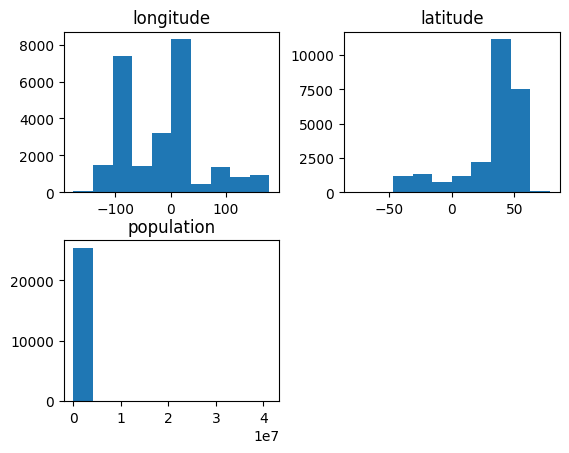

In [12]:
# Plot basic histograms of the numeric columns in the DataFrame.
msa_data.hist([COLNAME_LON, COLNAME_LAT, COLNAME_POP], grid=False)

In [13]:
# Because the "population" column is heavily skewed, transform it using the
# inverse hyperbolic sine transformation.
msa_data[COLNAME_POP_TRANS] = np.arcsinh(msa_data[COLNAME_POP])

array([[<Axes: title={'center': 'population_trans'}>]], dtype=object)

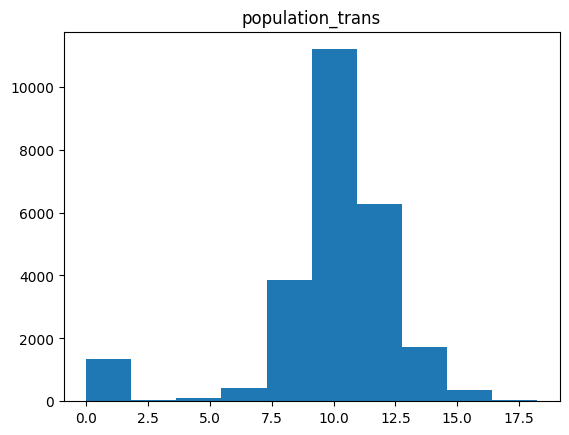

In [14]:
# Ensure that the transformation worked by plotting another histogram.
msa_data.hist(COLNAME_POP_TRANS, grid=False)

### NOTE:

    The above transformation worked properly, as the transformed population
    distribution now conforms much more to a normal distribution. This is
    advantageous, as it decreases the chances that downstream clustering
    models will be impacted by dramatic outlier points.

### NOTE:

    Normally at this stage, numeric columns should be standardized in some
    way (e.g., to a mean of 0 and a standard deviation of 1), such that
    they can be analyzed comparably in multi-dimensional space by a
    clustering model. However, this is not necessary in this case,
    because the clustering models here only consider two-dimensional spaces
    of the longitude and latitude columns, which are already spatially
    comparable in their raw form, or otherwise only consider
    one-dimensional spaces of just the population column. Attempting to
    standardize these columns led to a decline in clustering performance.

In [15]:
# Create a subset of the DataFrame that includes only the rows in the USA.
msa_data_usa = msa_data[msa_data[COLNAME_COUNTRY] == NAME_USA]

In [16]:
# Determine the names and frequencies of MSAs in the DataFrame subset.
# The output gives a useful summary of the most prominent MSAs, as well
# as how many MSAs exist in the USA.
msa_data_usa[COLNAME_MSA].value_counts()

msa
New York-Northern New Jersey-Long Island NY-NJ-PA MSA    526
Chicago-Naperville-Joliet IL-IN-WI MSA                   200
Philadelphia-Camden-Wilmington PA-NJ-DE-MD MSA           195
Boston-Cambridge-Quincy MA-NH MSA                        166
Los Angeles-Long Beach-Santa Ana CA MSA                  157
                                                        ... 
Missoula MT MSA                                            1
Lawrence KS MSA                                            1
Gainesville GA MSA                                         1
Decatur AL MSA                                             1
Owensboro KY MSA                                           1
Name: count, Length: 410, dtype: int64

In [17]:
# Create a version of the DataFrame subset that can be used for an initial
# plot, i.e., that includes only the rows with known MSA affiliations.
msa_data_usa_toplot = msa_data_usa[~msa_data_usa[COLNAME_MSA].isna()]

In [18]:
# Create a column of label encodings for the known MSAs in this DataFrame.
pd.options.mode.chained_assignment = None
msa_data_usa_toplot = encode_column(
    msa_data_usa_toplot, COLNAME_MSA, COLNAME_ENCODED
)

<Axes: xlabel='Longitude (Degrees)', ylabel='Latitude (Degrees)'>

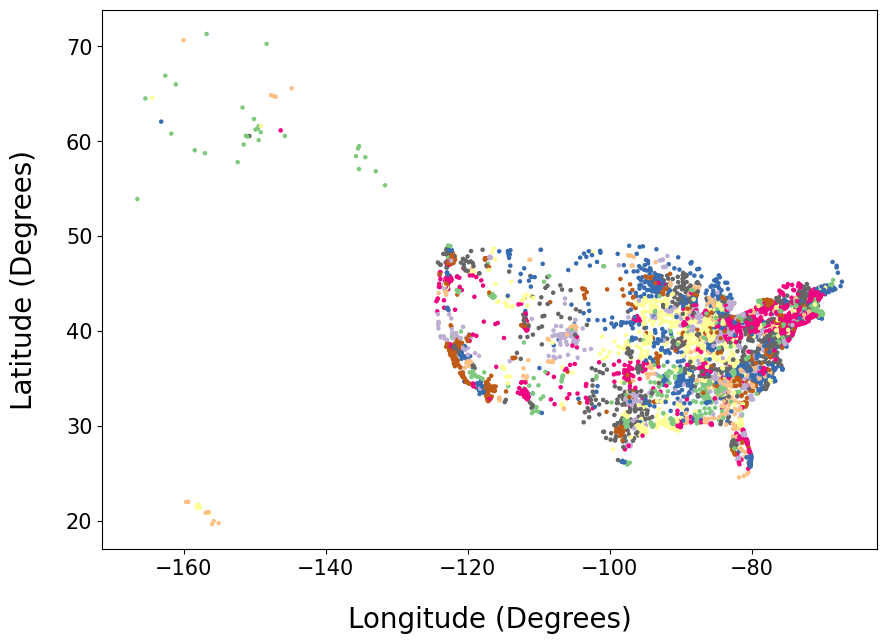

In [19]:
# Plot a scatterplot of the points in the DataFrame subset, where points are
# plotted by their lon/lat coordinates and colored by their MSA affiliation.
scatterplot_points(df=msa_data_usa_toplot)

### NOTE:

    The above plot indicates that standard MSAs are indeed grouped into
    clusters across space. However, particularly east of the Mississippi
    River, many of the clusters appear to overlap. It would be interesting
    to discuss the pros and cons of this overlap with practitioners.

In [20]:
# Build a weighted k-means clustering model that groups points in the USA
# by their coordinates, and weights the grouping by the points' populations.
# Then, build a DBSCAN model that subdivides the k-means clusters based on
# the populations of the points in each cluster.
msa_data_usa = model_clustering_algorithm(df=msa_data_usa)

In [21]:
# Count the number of modeled clusters.
print(msa_data_usa[COLNAME_CLUSTER_FINAL].nunique())

329


### NOTE:

    The number of modeled clusters is somewhat fewer than the number of
    standard MSAs that exist (410), although not necessarily by a
    critically significant amount. It would be interesting to discuss
    the potential advantages of designating fewer MSAs, if any.

In [22]:
# Evaluate the final clustering model output using the silhouette score.
print(model_evaluate_clusters(df=msa_data_usa))

0.3243343851933765


### NOTE:

    A silhouette score between 0.25 - 0.5 (on a scale of -1 = poorest
    clustering to 1 = perfect clustering) indicates that the clustering
    model performed fairly. The fact that the model is not perfect may
    be a result of the close proximity of many cities to each other,
    particularly in the regions east of the Mississippi River.

<Axes: xlabel='Longitude (Degrees)', ylabel='Latitude (Degrees)'>

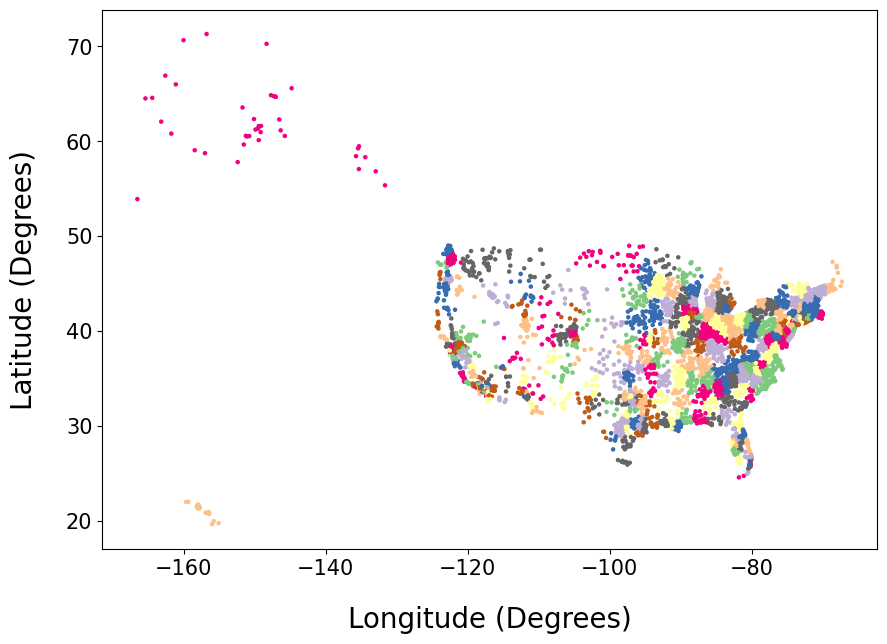

In [23]:
# Visualize the modeled clusters.
scatterplot_points(df=msa_data_usa, colname_c=COLNAME_CLUSTER_FINAL)

### NOTE:

    Unlike the previous plot of standard MSAs, the above plot of modeled
    MSAs shows clusters of MSAs that appear to exhibit considerably less
    overlap, particularly to the east of the Mississippi River. Thus, at
    first glance, it appears that the model can better distinguish between
    groups of cities in terms of their arrangement across space. It would
    be worthwhile to discuss this further with practitioners and to probe
    the advantages and disadvantages of MSAs that have limited overlap.

3267
0.2946343034947863


<Axes: xlabel='Longitude (Degrees)', ylabel='Latitude (Degrees)'>

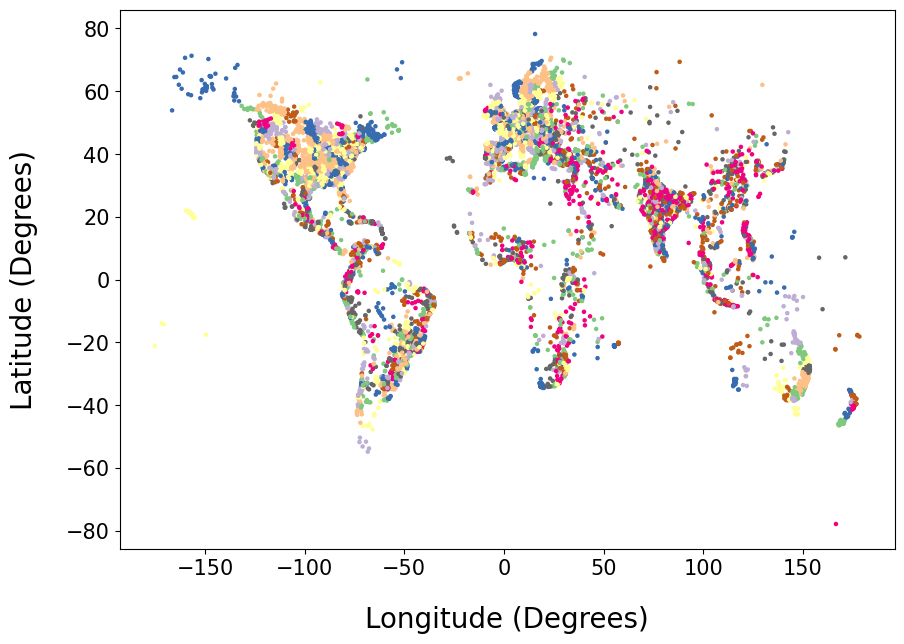

In [24]:
# Repeat the above modeling procedure for all global points.
msa_data_final = model_clustering_algorithm(df=msa_data)
print(msa_data_final[COLNAME_CLUSTER_FINAL].nunique())
print(model_evaluate_clusters(df=msa_data_final))
scatterplot_points(df=msa_data_final, colname_c=COLNAME_CLUSTER_FINAL)

### NOTE:

    This global analysis gives a good sense of how many MSAs we might expect
    to exist across the world. It reveals regions where many MSAs would exist
    in tightly packed space (e.g., India), as well as regions where few MSAs
    would exist across more space (e.g., western Australia). Its model
    performance is comparable to that of the model built on the USA only.

In [25]:
# Store the modeling outputs in a CSV file.
colnames_output = (['city', 'state', COLNAME_LAT, COLNAME_LON, COLNAME_POP,
                   COLNAME_MSA, COLNAME_CLUSTER_FINAL])
msa_data_final = msa_data_final[colnames_output]
msa_data_final.to_csv('msa_data_final.csv', index=False)